In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
processed_data_path = '../data/processed/'
raw_data_path = '../data/raw/'

name = 'hd'

reviews_pro = pd.read_csv(processed_data_path + name + '_reviews.csv')
resumme_raw = pd.read_csv(raw_data_path + 'resumme_' + name + '.csv')

display(resumme_raw)
display(reviews_pro.sample(5))

reviews = reviews_pro.copy()
resumme = resumme_raw.copy()

,stars,reviews
0,5,2290
1,4,1308
2,3,396
3,2,132
4,1,128


,review_id,review,local_guide_reviews,rating_score,service,meal_type,price_per_person_category,food_score,service_score,atmosphere_score,recommendations_list,date,avg_price_per_person
140,140,Llevo años pidiendo la famosa egg-burger.\nInc...,24.0,5.0,Comí allí,Cena,20-30 €,5.0,5.0,5.0,['Hamburguesa Completa Con Huevo'],2024-01-01,30.0
286,286,Precioso lugar,9.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2018-01-01,NaN
27,27,Buen local con terraza. Las hamburguesas están...,612.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2021-01-01,NaN
222,222,Un lugar muy agradable para relajarse y disfru...,20.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2017-01-01,NaN
94,94,Iba con optimismo ya que tengo aprecio a este ...,47.0,2.0,Comí allí,Brunch,NaN,NaN,NaN,NaN,[''],2022-01-01,NaN


### First draft summary plots 

In [5]:
# Calculate the average for each score
average_food = reviews['food_score'].mean()
average_service = reviews['service_score'].mean()
average_atmosphere = reviews['atmosphere_score'].mean()
average_reviews = (resumme_raw['stars'] * resumme_raw['reviews']).sum() / resumme_raw['reviews'].sum()

# Create a figure with horizontal subplots
fig = make_subplots(rows=1, cols=3, 
                    specs=[[{"type": "xy"}, {"type": "bar"}, {"type": "bar"}]], 
                    subplot_titles=("Average Score", "Number of Reviews", "Categories"))

# First subplot: Display the average review as large text
fig.add_trace(
    go.Scatter(x=[0], y=[0], text=[f"{average_reviews:.2f}"], mode="text", textfont=dict(size=120)),
    row=1, col=1
)

fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)
fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)


# Second subplot: Bar plot for reviews
fig.add_trace(
    go.Bar(x=resumme_raw['reviews'], y=resumme_raw['stars'], marker=dict(color='lightskyblue'),
           text=resumme_raw['reviews'], textposition='auto', name="Reviews", orientation='h'),
    row=1, col=2
)

# Third subplot: Bar plot for categories (Food, Service, Atmosphere)
fig.add_trace(
    go.Bar(x=[average_food, average_service, average_atmosphere], 
           y=['Food', 'Service', 'Atmosphere'], 
           marker=dict(color='lightgreen'), 
           text=[f"{average_food:.2f}", f"{average_service:.2f}", f"{average_atmosphere:.2f}"], 
           textposition='auto', 
           orientation='h', 
           name="Categories"),
    row=1, col=3
)

# Update layout
fig.update_layout(height=500, width=1200,  plot_bgcolor="white", paper_bgcolor="white", showlegend=False)

# Show the plot
fig.show()

In [6]:
# Convert date column to datetime format
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
reviews['month'] = reviews['date'].dt.to_period('M')
reviews['year'] = reviews['date'].dt.year
reviews['week'] = reviews['date'].dt.to_period('W')
reviews['week'] = reviews['date'] - pd.to_timedelta(reviews['date'].dt.weekday, unit='d')
reviews['week'] = reviews['week'].dt.strftime('%Y-%m-%d')

# Filter data for the last periods (months, years, weeks)
last_months = reviews[reviews['date'] >= pd.to_datetime('today') - pd.DateOffset(months=12)]
last_years = reviews[reviews['date'] >= pd.to_datetime('today') - pd.DateOffset(years=8)]
last_weeks = reviews[reviews['date'] >= pd.to_datetime('today') - pd.DateOffset(weeks=5)]

# Compute averages for the required periods
monthly_avg_scores = last_months.groupby('month')[['rating_score', 'food_score', 'service_score', 'atmosphere_score']].mean()
yearly_avg_scores = last_years.groupby('year')[['rating_score']].mean()
weekly_avg_scores = last_weeks.groupby('week')[['rating_score', 'food_score', 'service_score', 'atmosphere_score']].mean()

# Update the axis labels for each score to be more readable
label_mapping = {
    'rating_score': 'Rating',
    'food_score': 'Food',
    'service_score': 'Service',
    'atmosphere_score': 'Atmosphere'
}

# Create a figure with subplots using the Z-layout
fig = make_subplots(rows=2, cols=2,
                    specs=[[{"colspan": 2}, None],
                           [{}, {}]],  # 1 large plot on the first row, 2 smaller plots on the second
                    subplot_titles=("Monthly Score Trends (Last 12 Months)", 
                                    "Annual Rating Score Trends (Last 6 Years)", 
                                    "Weekly Score Trends (Last 4 Weeks)"))

# Add monthly score trends to the first row (rating_score in stronger color)
colors = ['#1f77b4', '#aec7e8', '#aec7e8', '#aec7e8']  # Same tonal range, rating_score stronger
for i, column in enumerate(monthly_avg_scores.columns):
    label = label_mapping[column]  # Get the readable label
    fig.add_trace(
        go.Scatter(x=monthly_avg_scores.index.astype(str), y=monthly_avg_scores[column],
                   mode='lines+markers', name=label, 
                   text=[f"{label} - {val:.2f}" for val in monthly_avg_scores[column]], 
                   hoverinfo="text", line=dict(color=colors[i])),
        row=1, col=1)

# Add yearly score trends to the second row (left)
fig.add_trace(
    go.Scatter(x=yearly_avg_scores.index.astype(str), y=yearly_avg_scores['rating_score'],
               mode='lines+markers', name="Rating", line=dict(color='#1f77b4', width=4),
               text=[f"Rating - {val:.2f}" for val in yearly_avg_scores['rating_score']], 
               hoverinfo="text"),
    row=2, col=1)

# Add weekly score trends to the second row (right, weaker colors)
for i, column in enumerate(weekly_avg_scores.columns):
    label = label_mapping[column]  # Get the readable label
    fig.add_trace(
        go.Scatter(x=weekly_avg_scores.index.astype(str), y=weekly_avg_scores[column],
                   mode='lines+markers', name=label, 
                   text=[f"{label} - {val:.2f}" for val in weekly_avg_scores[column]], 
                   hoverinfo="text", line=dict(color=colors[i])),
        row=2, col=2)

# Enhance presentation: remove gridlines and borders, increase size, and remove legend
fig.update_layout(showlegend=False, 
                  title="Score Trends Analysis",
                  title_font=dict(size=28),
                  margin=dict(l=50, r=50, t=100, b=50),
                  paper_bgcolor="white",
                  height=800, width=1200)

# Remove unnecessary gridlines for a cleaner look
fig.update_xaxes(showline=False, showgrid=False)
fig.update_yaxes(showline=False, showgrid=True)

# Customize x-axes formatting: show only the year for yearly data, and only day and month for weekly data
fig.update_xaxes(
    tickformat="%Y",  # Only show the year for the yearly graph
    row=2, col=1
)

fig.update_xaxes(
    tickformat="%d-%b",  # Show only the day and month for weekly graph
    row=2, col=2
)

# Add annotations to highlight key points
fig.add_annotation(x='2024-06', y=4.8, 
                   text="Highest Score", 
                   showarrow=True, arrowhead=2,
                   ax=0, ay=80, row=1, col=1, font=dict(size=14))

fig.add_annotation(x='2024-03', y=4.5, 
                   text="Drop in March", 
                   showarrow=True, arrowhead=2,
                   ax=0, ay=-40, row=1, col=1, font=dict(size=14))

fig.add_annotation(x='2024-08', y=4.5, 
                   text="Drop in August", 
                   showarrow=True, arrowhead=2,
                   ax=0, ay=-40, row=1, col=1, font=dict(size=14))

# Improve line aesthetics (rating score with more prominence)
fig.update_traces(marker=dict(size=8), selector=dict(name="Rating"))

# Display the interactive plot
fig.show()


### Cleaning and preprocessing

In [3]:
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


from tqdm import tqdm



# Download NLTK stopwords
nltk.download('stopwords')

# Load spaCy Spanish model
nlp = spacy.load('es_core_news_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jobandtalent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Clean text, stopworks and tokenize words
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-záéíóúñü0-9\s]', '', text)
    doc = nlp(text)
    stop_words = set(stopwords.words('spanish'))
    tokens = [token.lemma_ for token in doc 
              if token.text not in stop_words and not token.is_punct and not token.is_space]
    return ' '.join(tokens)

In [6]:
tqdm.pandas(desc="Cleaning Reviews")
reviews['cleaned_review'] = reviews['review'].fillna('').progress_apply(clean_text)

display(reviews[['review', 'cleaned_review']].sample(5))

Cleaning Reviews: 100%|██████████| 360/360 [00:02<00:00, 154.30it/s]


,review,cleaned_review
143,La hamburguesa italiana de las mejores q he pr...,hamburguesa italiano mejor q probar precio raz...
25,Cafetería emblemática madrileña abierta por lo...,cafetería emblemático madrileño abierto herman...
117,"UN LOCAL CON AIRE OCHENTERO DONDE EL SERVICIO,...",local aire ochentero servicio calidad variedad...
12,Fui por casualidad con unos amigos... me encan...,casualidad amigo encantar hamburguesa espectác...
13,Un clásico en la zona de Chamberí.\n\nPROS: la...,clásico zona chamberir pro hamburguesa genial ...


### Embeddings and sentiment analysis

In [7]:
# Embeddings and Sentiment
from transformers import pipeline
from transformers import BertTokenizer, BertModel
import torch

# Word Clouds and Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Extract the embeddings for each cleaned review
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Import Bert model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

tqdm.pandas(desc="Generating Embeddings")
reviews['embedding'] = reviews['cleaned_review'].progress_apply(get_embedding)

Generating Embeddings: 100%|██████████| 360/360 [00:30<00:00, 11.82it/s]


In [9]:
reviews

,review_id,review,local_guide_reviews,rating_score,service,meal_type,price_per_person_category,food_score,service_score,atmosphere_score,recommendations_list,date,avg_price_per_person,cleaned_review,embedding
0,0,Además de que da un vibra de un bar de los 50’...,92.0,5.0,NaN,NaN,NaN,5.0,5.0,5.0,[''],2024-09-09,NaN,además dar vibra bar 50s hamburguesa descubrim...,"[-0.39345536, -0.33803207, 0.34808198, 0.19436..."
1,1,La hamburguesa de pollo frito estaba muy rica ...,35.0,4.0,Comí allí,Comida,30-40 €,4.0,5.0,4.0,[''],2024-08-01,40.0,hamburguesa pollo frito rico acuerdo nombre ca...,"[-0.13622372, -0.16634203, 0.5213568, 0.331580..."
2,2,Estuve cenando en familia el martes y además d...,2.0,5.0,NaN,NaN,NaN,5.0,5.0,5.0,[''],2024-09-16,NaN,cenar familia martes además excelente atención...,"[-0.29606187, -0.28629205, 0.2620312, 0.217695..."
3,3,Solo tomamos un vermút y una cerveza. El bar m...,11.0,3.0,NaN,NaN,NaN,NaN,3.0,3.0,[''],2024-05-01,NaN,solo tomar vermút cerveza bar molo cafeteer sa...,"[-0.36835817, -0.26008305, 0.064508475, 0.3708..."
4,4,"Un gofre frío y tieso 9,20€? Nunca me había se...",58.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0,[''],NaN,NaN,gofre frío tieso 920 nunca tanto estafado 3 ba...,"[9.475763e-05, -0.38498864, -0.15247194, 0.622..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355,NaN,81.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2023-01-01,NaN,,"[0.1206212, -0.15257965, 1.012721, 0.37729222,..."
356,356,NaN,30.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2023-01-01,NaN,,"[0.1206212, -0.15257965, 1.012721, 0.37729222,..."
357,357,NaN,51.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2023-01-01,NaN,,"[0.1206212, -0.15257965, 1.012721, 0.37729222,..."
358,358,NaN,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2023-01-01,NaN,,"[0.1206212, -0.15257965, 1.012721, 0.37729222,..."


In [13]:
def analyze_sentiment(text):
    sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
    result = sentiment_pipeline(text[:512])[0]  # Truncate to 512 tokens
    return result['label']

tqdm.pandas(desc="Sentiment Analysis")
reviews['sentiment'] = reviews['cleaned_review'].progress_apply(analyze_sentiment)

# Map sentiments to categories
sentiment_mapping = {
    '1 star': 'Negative',
    '2 stars': 'Negative',
    '3 stars': 'Neutral',
    '4 stars': 'Positive',
    '5 stars': 'Positive'
}

reviews['sentiment_category'] = reviews['sentiment'].map(sentiment_mapping)


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Sentiment Analysis: 100%|██████████| 360/360 [00:24<00:00, 14.51it/s]


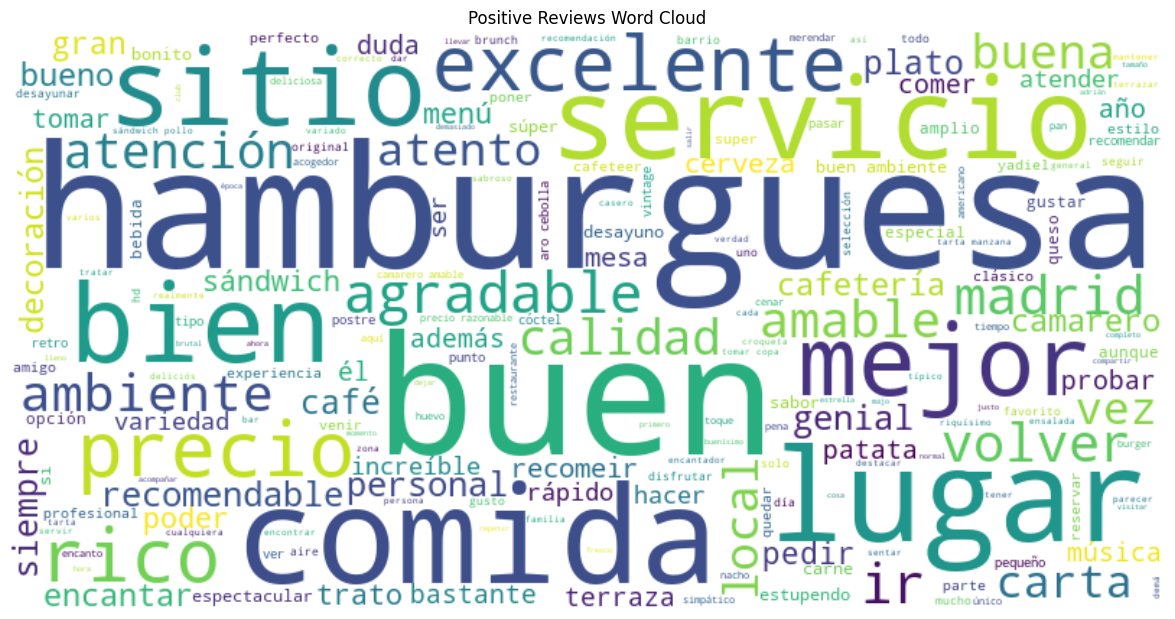

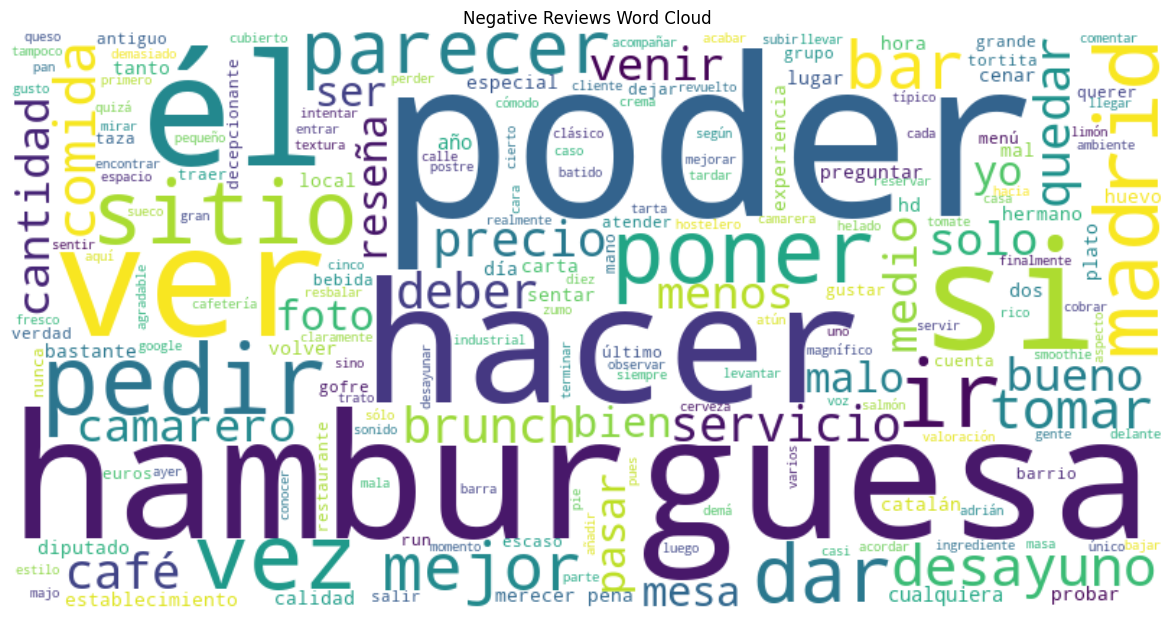

In [18]:
positive_reviews = reviews[reviews['sentiment_category'] == 'Positive']['cleaned_review']
negative_reviews = reviews[reviews['sentiment_category'] == 'Negative']['cleaned_review']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Display Positive Word Cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

# Display Negative Word Cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.express as px

# Initialize TF-IDF Vectorizer with Spanish stopwords
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('spanish'))

# Fit the vectorizer on all cleaned reviews
vectorizer.fit(reviews['cleaned_review'])

# Transform positive and negative reviews
positive_reviews = reviews[reviews['sentiment_category'] == 'Positive']['cleaned_review']
negative_reviews = reviews[reviews['sentiment_category'] == 'Negative']['cleaned_review']

tfidf_pos = vectorizer.transform(positive_reviews)
tfidf_neg = vectorizer.transform(negative_reviews)



In [32]:
# Create DataFrames with consistent columns
tfidf_pos_df = pd.DataFrame(tfidf_pos.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_neg_df = pd.DataFrame(tfidf_neg.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate mean TF-IDF scores for each term
tfidf_pos_mean = tfidf_pos_df.mean().sort_values(ascending=False)
tfidf_neg_mean = tfidf_neg_df.mean().sort_values(ascending=False)

# Select top 5 terms for each sentiment
top5_positive = tfidf_pos_mean.head(5).index.tolist()
top5_negative = tfidf_neg_mean.head(5).index.tolist()

# Identify common terms
common_terms = set(top5_positive).intersection(set(top5_negative))

# Extract distinct top terms
distinct_positive = [term for term in top5_positive if term not in common_terms]
distinct_negative = [term for term in top5_negative if term not in common_terms]

print("Distinct Top 5 Positive Terms:", distinct_positive)
print("Distinct Top 5 Negative Terms:", distinct_negative)



Distinct Top 5 Positive Terms: ['buen', 'hamburguesa', 'lugar', 'comida', 'bien']
Distinct Top 5 Negative Terms: ['poder', 'si', 'vez', 'pedir', 'ver']


In [35]:
# Function to find matching terms in a review
def find_terms(text, terms):
    return [term for term in terms if re.search(r'\b' + re.escape(term) + r'\b', text)]

# Extract positive reviews containing distinct_positive terms
reviews['matched_positive_terms'] = reviews['cleaned_review'].apply(lambda x: find_terms(x, distinct_positive))
positive_reviews = reviews[reviews['matched_positive_terms'].map(len) > 0]

# Extract negative reviews containing distinct_negative terms
reviews['matched_negative_terms'] = reviews['cleaned_review'].apply(lambda x: find_terms(x, distinct_negative))
negative_reviews = reviews[reviews['matched_negative_terms'].map(len) > 0]

# Select relevant columns
positive_reviews = positive_reviews[['review_id', 'review', 'date', 'sentiment_category', 'matched_positive_terms']]
negative_reviews = negative_reviews[['review_id', 'review', 'date', 'sentiment_category', 'matched_negative_terms']]

# Display samples
print("Sample Positive Reviews:")
display(positive_reviews.sample(5))

print("Sample Negative Reviews:")
display(negative_reviews.sample(5))



Sample Positive Reviews:


,review_id,review,date,sentiment_category,matched_positive_terms
35,35,Cafetería en la calle Gaztambide del grupo la ...,2022-01-01,Positive,"[buen, hamburguesa, comida, bien]"
225,225,Antigua cafetería reformada pero manteniendo e...,2017-01-01,Positive,"[hamburguesa, comida]"
259,259,Muy buenos bocadillos y hamburguesas.,2024-08-01,Positive,"[buen, hamburguesa]"
174,174,Sitio brutal para comer hamburguesas. El pan d...,2023-01-01,Positive,[hamburguesa]
133,133,"Somos clientes habituales, la comida está riqu...",2024-05-01,Positive,[comida]


Sample Negative Reviews:


,review_id,review,date,sentiment_category,matched_negative_terms
168,168,"excelente sitio, muy agradable, con ricas hamb...",2023-11-01,Positive,[poder]
107,107,"Estupenda cafetería con aire retro, y enorme t...",2023-01-01,Positive,[si]
29,29,WoW! Este establecimiento es de los más especi...,2023-01-01,Negative,"[poder, si]"
94,94,Iba con optimismo ya que tengo aprecio a este ...,2022-01-01,Negative,"[poder, vez, pedir, ver]"
128,128,"Local de estética antigua, con una carta ampli...",2020-01-01,Neutral,[poder]


review    Acudí para desayunar y todo fue bien. La comid...
Name: 45, dtype: object

In [34]:
# Extract year and month
reviews['year_month'] = reviews['date'].dt.to_period('M').dt.to_timestamp()

# Function to calculate term frequency
def term_frequency(df, terms):
    freq_df = pd.DataFrame()
    for term in terms:
        # Use word boundaries to match exact terms
        freq_df[term] = df['cleaned_review'].str.contains(r'\b' + re.escape(term) + r'\b').astype(int)
    freq_df['year_month'] = df['year_month']
    return freq_df.groupby('year_month').sum().reset_index()

# Calculate frequency for distinct positive and negative terms
freq_pos = term_frequency(reviews[reviews['sentiment_category'] == 'Positive'], distinct_positive)
freq_neg = term_frequency(reviews[reviews['sentiment_category'] == 'Negative'], distinct_negative)

# Melt DataFrames for Plotly
freq_pos_melted = freq_pos.melt(id_vars='year_month', var_name='Term', value_name='Count')
freq_neg_melted = freq_neg.melt(id_vars='year_month', var_name='Term', value_name='Count')

# Interactive plot for positive terms
fig_pos = px.line(freq_pos_melted, x='year_month', y='Count', color='Term',
                 title='Temporal Evolution of Top Positive Terms',
                 labels={'year_month': 'Date', 'Count': 'Frequency'},
                 markers=True)
fig_pos.update_layout(hovermode='x unified')
fig_pos.show()

# Interactive plot for negative terms
fig_neg = px.line(freq_neg_melted, x='year_month', y='Count', color='Term',
                 title='Temporal Evolution of Top Negative Terms',
                 labels={'year_month': 'Date', 'Count': 'Frequency'},
                 markers=True)
fig_neg.update_layout(hovermode='x unified')
fig_neg.show()


In [30]:
# Extraer año y mes
reviews['year_month'] = reviews['date'].dt.to_period('M').dt.to_timestamp()

# Función para calcular frecuencia de términos
def term_frequency(df, terms):
    freq_df = pd.DataFrame()
    for term in terms:
        freq_df[term] = df['cleaned_review'].str.contains(r'\b' + re.escape(term) + r'\b').astype(int)
    freq_df['year_month'] = df['year_month']
    return freq_df.groupby('year_month').sum().reset_index()

# Calcular frecuencia para términos positivos y negativos
freq_pos = term_frequency(reviews[reviews['sentiment_category'] == 'Positive'], top5_positive)
freq_neg = term_frequency(reviews[reviews['sentiment_category'] == 'Negative'], top5_negative)

# Combinar dataframes
freq_pos_melted = freq_pos.melt(id_vars='year_month', var_name='Term', value_name='Count')
freq_neg_melted = freq_neg.melt(id_vars='year_month', var_name='Term', value_name='Count')

# Gráfico interactivo para términos positivos
fig_pos = px.line(freq_pos_melted, x='year_month', y='Count', color='Term',
                 title='Evolución Temporal de Términos Positivos',
                 labels={'year_month': 'Fecha', 'Count': 'Frecuencia'})
fig_pos.update_layout(hovermode='x unified')
fig_pos.show()

# Gráfico interactivo para términos negativos
fig_neg = px.line(freq_neg_melted, x='year_month', y='Count', color='Term',
                 title='Evolución Temporal de Términos Negativos',
                 labels={'year_month': 'Fecha', 'Count': 'Frecuencia'})
fig_neg.update_layout(hovermode='x unified')
fig_neg.show()


In [31]:
# Extract year and month
reviews['year_month'] = reviews['date'].dt.to_period('M')

# Aggregate sentiments
sentiment_trend = reviews.groupby(['year_month', 'sentiment_category']).size().unstack(fill_value=0).reset_index()
sentiment_trend['year_month'] = sentiment_trend['year_month'].dt.to_timestamp()

# Sort by date
sentiment_trend = sentiment_trend.sort_values('year_month')


# Initialize the figure
fig = go.Figure()

# Add traces for each sentiment category
fig.add_trace(go.Scatter(
    x=sentiment_trend['year_month'],
    y=sentiment_trend['Positive'],
    mode='lines+markers',
    name='Positive',
    line=dict(color='green')
))

fig.add_trace(go.Scatter(
    x=sentiment_trend['year_month'],
    y=sentiment_trend['Neutral'],
    mode='lines+markers',
    name='Neutral',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=sentiment_trend['year_month'],
    y=sentiment_trend['Negative'],
    mode='lines+markers',
    name='Negative',
    line=dict(color='red')
))

# Update layout for better aesthetics
fig.update_layout(
    title='Temporal Evolution of Sentiment',
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    hovermode='x unified'
)

# Show the interactive plot
fig.show()
